In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Install dependencies
!pip install -q open_clip_torch einops timm tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00


In [5]:
# ===== CELL 1: IMPORTS =====
import os, sys, math, time, random, gc
from pathlib import Path
from typing import List, Tuple, Optional, Union, Sequence
from functools import partial
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import open_clip

print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch: 2.9.0+cu126, CUDA: True
Device: cuda
GPU: Tesla T4
Memory: 15.8 GB


In [6]:
# ===== CELL 2: CONFIG =====
class Config:
    # Paths
    data_path = '/content/drive/MyDrive/flowers_dataset'
    output_dir = '/content/drive/MyDrive/var_flowers_correct'
    vae_path = '/content/drive/MyDrive/vae_ch160v4096z32.pth'

    # VAR Model (matching original architecture scaling)
    # Original uses: width = depth * 64, heads = depth
    # For small model: depth=12 -> width=768, heads=12 (~85M params)
    # For tiny model: depth=8 -> width=512, heads=8 (~40M params)
    var_depth = 12
    var_embed_dim = 768  # depth * 64
    var_num_heads = 12   # depth
    var_mlp_ratio = 4.0
    var_drop_path = 0.1 * 12 / 24  # 0.05
    var_attn_l2_norm = True
    var_cond_drop = 0.1

    # VQVAE (fixed)
    n_cond_embed = 768
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
    V = 4096
    Cvae = 32
    ch = 160

    # Training
    batch_size = 8
    grad_accum = 2
    epochs = 100
    base_lr = 1e-4
    min_lr = 1e-6
    weight_decay = 0.05
    warmup_epochs = 5
    label_smoothing = 0.1
    grad_clip = 1.0

    # Data
    image_size = 256
    hflip = True
    seed = 42
    log_every = 50
    save_every = 10
    generate_every = 10

cfg = Config()
os.makedirs(cfg.output_dir, exist_ok=True)

# Set seeds
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(cfg.seed)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print(f"✓ Config ready")
print(f"  VAR: depth={cfg.var_depth}, dim={cfg.var_embed_dim}, heads={cfg.var_num_heads}")

✓ Config ready
  VAR: depth=12, dim=768, heads=12


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [7]:
# ===== CELL 3: HELPER MODULES =====

def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0:
        random_tensor.div_(keep_prob)
    return x * random_tensor

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

def Normalize(in_channels, num_groups=32):
    return nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)

print("✓ Helper modules defined")

✓ Helper modules defined


In [8]:
# ===== CELL 4: VAE COMPONENTS (matching original VAR codebase) =====

class Upsample2x(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv(F.interpolate(x, scale_factor=2, mode='nearest'))

class Downsample2x(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x):
        return self.conv(F.pad(x, pad=(0, 1, 0, 1), mode='constant', value=0))

class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, dropout):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels

        self.norm1 = Normalize(in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.norm2 = Normalize(out_channels)
        self.dropout = nn.Dropout(dropout) if dropout > 1e-6 else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        if self.in_channels != self.out_channels:
            self.nin_shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.nin_shortcut = nn.Identity()

    def forward(self, x):
        h = self.conv1(F.silu(self.norm1(x)))
        h = self.conv2(self.dropout(F.silu(self.norm2(h))))
        return self.nin_shortcut(x) + h

class AttnBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.C = in_channels
        self.norm = Normalize(in_channels)
        self.qkv = nn.Conv2d(in_channels, 3*in_channels, kernel_size=1, stride=1, padding=0)
        self.w_ratio = int(in_channels) ** (-0.5)
        self.proj_out = nn.Conv2d(in_channels, in_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        qkv = self.qkv(self.norm(x))
        B, _, H, W = qkv.shape
        C = self.C
        q, k, v = qkv.reshape(B, 3, C, H, W).unbind(1)

        q = q.view(B, C, H * W).permute(0, 2, 1)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k).mul_(self.w_ratio)
        w = F.softmax(w, dim=2)

        v = v.view(B, C, H * W)
        w = w.permute(0, 2, 1)
        h = torch.bmm(v, w)
        h = h.view(B, C, H, W)

        return x + self.proj_out(h)

def make_attn(in_channels, using_sa=True):
    return AttnBlock(in_channels) if using_sa else nn.Identity()

print("✓ VAE components defined")

✓ VAE components defined


In [9]:
# ===== CELL 5: ENCODER & DECODER =====

class Encoder(nn.Module):
    def __init__(self, *, ch=128, ch_mult=(1, 2, 4, 8), num_res_blocks=2,
                 dropout=0.0, in_channels=3, z_channels, double_z=False,
                 using_sa=True, using_mid_sa=True):
        super().__init__()
        self.ch = ch
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks

        self.conv_in = nn.Conv2d(in_channels, self.ch, kernel_size=3, stride=1, padding=1)

        in_ch_mult = (1,) + tuple(ch_mult)
        self.down = nn.ModuleList()
        block_in = ch
        for i_level in range(self.num_resolutions):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_in = ch * in_ch_mult[i_level]
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, dropout=dropout))
                block_in = block_out
                if i_level == self.num_resolutions - 1 and using_sa:
                    attn.append(make_attn(block_in, using_sa=True))
            down = nn.Module()
            down.block = block
            down.attn = attn
            if i_level != self.num_resolutions - 1:
                down.downsample = Downsample2x(block_in)
            self.down.append(down)

        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, using_sa=using_mid_sa)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, dropout=dropout)

        self.norm_out = Normalize(block_in)
        self.conv_out = nn.Conv2d(block_in, (2 * z_channels if double_z else z_channels), kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        h = self.conv_in(x)
        for i_level in range(self.num_resolutions):
            for i_block in range(self.num_res_blocks):
                h = self.down[i_level].block[i_block](h)
                if len(self.down[i_level].attn) > 0:
                    h = self.down[i_level].attn[i_block](h)
            if i_level != self.num_resolutions - 1:
                h = self.down[i_level].downsample(h)

        h = self.mid.block_2(self.mid.attn_1(self.mid.block_1(h)))
        h = self.conv_out(F.silu(self.norm_out(h)))
        return h

class Decoder(nn.Module):
    def __init__(self, *, ch=128, ch_mult=(1, 2, 4, 8), num_res_blocks=2,
                 dropout=0.0, in_channels=3, z_channels, using_sa=True, using_mid_sa=True):
        super().__init__()
        self.ch = ch
        self.num_resolutions = len(ch_mult)
        self.num_res_blocks = num_res_blocks

        block_in = ch * ch_mult[self.num_resolutions - 1]

        self.conv_in = nn.Conv2d(z_channels, block_in, kernel_size=3, stride=1, padding=1)

        self.mid = nn.Module()
        self.mid.block_1 = ResnetBlock(in_channels=block_in, out_channels=block_in, dropout=dropout)
        self.mid.attn_1 = make_attn(block_in, using_sa=using_mid_sa)
        self.mid.block_2 = ResnetBlock(in_channels=block_in, out_channels=block_in, dropout=dropout)

        self.up = nn.ModuleList()
        for i_level in reversed(range(self.num_resolutions)):
            block = nn.ModuleList()
            attn = nn.ModuleList()
            block_out = ch * ch_mult[i_level]
            for i_block in range(self.num_res_blocks + 1):
                block.append(ResnetBlock(in_channels=block_in, out_channels=block_out, dropout=dropout))
                block_in = block_out
                if i_level == self.num_resolutions - 1 and using_sa:
                    attn.append(make_attn(block_in, using_sa=True))
            up = nn.Module()
            up.block = block
            up.attn = attn
            if i_level != 0:
                up.upsample = Upsample2x(block_in)
            self.up.insert(0, up)

        self.norm_out = Normalize(block_in)
        self.conv_out = nn.Conv2d(block_in, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, z):
        h = self.mid.block_2(self.mid.attn_1(self.mid.block_1(self.conv_in(z))))

        for i_level in reversed(range(self.num_resolutions)):
            for i_block in range(self.num_res_blocks + 1):
                h = self.up[i_level].block[i_block](h)
                if len(self.up[i_level].attn) > 0:
                    h = self.up[i_level].attn[i_block](h)
            if i_level != 0:
                h = self.up[i_level].upsample(h)

        h = self.conv_out(F.silu(self.norm_out(h)))
        return h

print("✓ Encoder & Decoder defined")

✓ Encoder & Decoder defined


In [10]:
# ===== CELL 6: VECTOR QUANTIZER =====

class Phi(nn.Conv2d):
    def __init__(self, embed_dim, quant_resi):
        ks = 3
        super().__init__(in_channels=embed_dim, out_channels=embed_dim, kernel_size=ks, stride=1, padding=ks//2)
        self.resi_ratio = abs(quant_resi)

    def forward(self, h_BChw):
        return h_BChw.mul(1 - self.resi_ratio) + super().forward(h_BChw).mul_(self.resi_ratio)

class PhiPartiallyShared(nn.Module):
    def __init__(self, qresi_ls: nn.ModuleList):
        super().__init__()
        self.qresi_ls = qresi_ls
        K = len(qresi_ls)
        self.ticks = np.linspace(1/3/K, 1-1/3/K, K) if K == 4 else np.linspace(1/2/K, 1-1/2/K, K)

    def __getitem__(self, at_from_0_to_1: float) -> Phi:
        return self.qresi_ls[np.argmin(np.abs(self.ticks - at_from_0_to_1)).item()]

class VectorQuantizer2(nn.Module):
    def __init__(self, vocab_size, Cvae, using_znorm=False, beta=0.25,
                 v_patch_nums=None, quant_resi=0.5, share_quant_resi=4):
        super().__init__()
        self.vocab_size = vocab_size
        self.Cvae = Cvae
        self.using_znorm = using_znorm
        self.v_patch_nums = v_patch_nums
        self.beta = beta

        self.embedding = nn.Embedding(vocab_size, Cvae)
        self.quant_resi = PhiPartiallyShared(nn.ModuleList([
            Phi(Cvae, quant_resi) for _ in range(share_quant_resi)
        ]))

        self.register_buffer('ema_vocab_hit_SV', torch.zeros(len(v_patch_nums), vocab_size))

    def f_to_idxBl_or_fhat(self, f_BChw, to_fhat, v_patch_nums=None):
        B, C, H, W = f_BChw.shape
        v_patch_nums = v_patch_nums or self.v_patch_nums

        f_no_grad = f_BChw.detach()
        f_rest = f_no_grad.clone()
        f_hat = torch.zeros_like(f_rest)

        results = []
        SN = len(v_patch_nums)

        for si, pn in enumerate(v_patch_nums):
            # Downsample to current scale
            if si < SN - 1:
                z_NC = F.interpolate(f_rest, size=(pn, pn), mode='area').permute(0, 2, 3, 1).reshape(-1, C)
            else:
                z_NC = f_rest.permute(0, 2, 3, 1).reshape(-1, C)

            # Find nearest embeddings
            if self.using_znorm:
                z_NC = F.normalize(z_NC, dim=-1)
                idx_N = torch.argmax(z_NC @ F.normalize(self.embedding.weight.T, dim=0), dim=1)
            else:
                d = torch.sum(z_NC ** 2, dim=1, keepdim=True) + \
                    torch.sum(self.embedding.weight ** 2, dim=1) - \
                    2 * z_NC @ self.embedding.weight.t()
                idx_N = torch.argmin(d, dim=1)

            idx_Bhw = idx_N.view(B, pn, pn)

            # Get quantized embeddings
            h_BChw = F.interpolate(self.embedding(idx_Bhw).permute(0, 3, 1, 2), size=(H, W), mode='bicubic') if (si < SN - 1) else self.embedding(idx_Bhw).permute(0, 3, 1, 2)
            h_BChw = self.quant_resi[si / (SN - 1)](h_BChw)
            f_hat = f_hat + h_BChw
            f_rest = f_rest - h_BChw

            if to_fhat:
                results.append(f_hat.clone())
            else:
                results.append(idx_N.view(B, pn * pn))

        return results

    def idxBl_to_var_input(self, gt_ms_idx_Bl: List[torch.Tensor]) -> torch.Tensor:
        next_scales = []
        B = gt_ms_idx_Bl[0].shape[0]
        C = self.Cvae
        H = W = self.v_patch_nums[-1]
        SN = len(self.v_patch_nums)

        f_hat = gt_ms_idx_Bl[0].new_zeros(B, C, H, W, dtype=torch.float32)
        pn_next = self.v_patch_nums[0]

        for si in range(SN - 1):
            h_BChw = F.interpolate(
                self.embedding(gt_ms_idx_Bl[si]).transpose(1, 2).view(B, C, pn_next, pn_next),
                size=(H, W), mode='bicubic'
            )
            f_hat = f_hat + self.quant_resi[si / (SN - 1)](h_BChw)
            pn_next = self.v_patch_nums[si + 1]
            next_scales.append(F.interpolate(f_hat, size=(pn_next, pn_next), mode='area').view(B, C, -1).transpose(1, 2))

        return torch.cat(next_scales, dim=1) if len(next_scales) else None

    def get_next_autoregressive_input(self, si: int, SN: int, f_hat: torch.Tensor, h_BChw: torch.Tensor):
        HW = self.v_patch_nums[-1]
        if si != SN - 1:
            h = self.quant_resi[si / (SN - 1)](F.interpolate(h_BChw, size=(HW, HW), mode='bicubic'))
            f_hat = f_hat + h
            return f_hat, F.interpolate(f_hat, size=(self.v_patch_nums[si + 1], self.v_patch_nums[si + 1]), mode='area')
        else:
            h = self.quant_resi[si / (SN - 1)](h_BChw)
            f_hat = f_hat + h
            return f_hat, f_hat

    def embed_to_fhat(self, ms_h_BChw: List[torch.Tensor], all_to_max_scale=True, last_one=False):
        B = ms_h_BChw[0].shape[0]
        H = W = self.v_patch_nums[-1]
        SN = len(self.v_patch_nums)

        f_hat = ms_h_BChw[0].new_zeros(B, self.Cvae, H, W, dtype=torch.float32)
        results = []

        for si, pn in enumerate(self.v_patch_nums):
            h_BChw = ms_h_BChw[si]
            if si < len(self.v_patch_nums) - 1:
                h_BChw = F.interpolate(h_BChw, size=(H, W), mode='bicubic')
            h_BChw = self.quant_resi[si / (SN - 1)](h_BChw)
            f_hat = f_hat + h_BChw
            if last_one:
                results = f_hat
            else:
                results.append(f_hat.clone())

        return results

print("✓ VectorQuantizer2 defined")

✓ VectorQuantizer2 defined


In [11]:
# ===== CELL 7: VQVAE =====

class VQVAE(nn.Module):
    def __init__(self, vocab_size=4096, z_channels=32, ch=160, dropout=0.0,
                 using_znorm=False, quant_conv_ks=3, quant_resi=0.5, share_quant_resi=4,
                 v_patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16), test_mode=True):
        super().__init__()
        self.test_mode = test_mode
        self.V, self.Cvae = vocab_size, z_channels
        self.vocab_size = vocab_size

        ddconfig = dict(
            dropout=dropout, ch=ch, z_channels=z_channels,
            in_channels=3, ch_mult=(1, 1, 2, 2, 4), num_res_blocks=2,
            using_sa=True, using_mid_sa=True,
        )

        self.encoder = Encoder(double_z=False, **ddconfig)
        self.decoder = Decoder(**ddconfig)

        self.quantize = VectorQuantizer2(
            vocab_size=vocab_size, Cvae=z_channels, using_znorm=using_znorm,
            v_patch_nums=v_patch_nums, quant_resi=quant_resi, share_quant_resi=share_quant_resi
        )

        self.quant_conv = nn.Conv2d(z_channels, z_channels, quant_conv_ks, stride=1, padding=quant_conv_ks // 2)
        self.post_quant_conv = nn.Conv2d(z_channels, z_channels, quant_conv_ks, stride=1, padding=quant_conv_ks // 2)

        if test_mode:
            self.eval()
            for p in self.parameters():
                p.requires_grad_(False)

    def img_to_idxBl(self, inp_img):
        f = self.quant_conv(self.encoder(inp_img))
        return self.quantize.f_to_idxBl_or_fhat(f, to_fhat=False)

    def fhat_to_img(self, f_hat):
        return self.decoder(self.post_quant_conv(f_hat)).clamp_(-1, 1)

    def idxBl_to_img(self, ms_idx_Bl, same_shape=True, last_one=False):
        B = ms_idx_Bl[0].shape[0]
        ms_h_BChw = []
        for idx_Bl in ms_idx_Bl:
            l = idx_Bl.shape[1]
            pn = round(l ** 0.5)
            ms_h_BChw.append(self.quantize.embedding(idx_Bl).transpose(1, 2).view(B, self.Cvae, pn, pn))
        return self.embed_to_img(ms_h_BChw, all_to_max_scale=same_shape, last_one=last_one)

    def embed_to_img(self, ms_h_BChw, all_to_max_scale, last_one=False):
        if last_one:
            f_hat = self.quantize.embed_to_fhat(ms_h_BChw, all_to_max_scale=all_to_max_scale, last_one=True)
            return self.decoder(self.post_quant_conv(f_hat)).clamp_(-1, 1)
        else:
            f_hats = self.quantize.embed_to_fhat(ms_h_BChw, all_to_max_scale=all_to_max_scale, last_one=False)
            return [self.decoder(self.post_quant_conv(f_hat)).clamp_(-1, 1) for f_hat in f_hats]

print("✓ VQVAE defined")

✓ VQVAE defined


In [12]:
# ===== CELL 8: VAR TRANSFORMER COMPONENTS =====

class SelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, attn_drop=0., proj_drop=0., attn_l2_norm=True):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.attn_l2_norm = attn_l2_norm

        if attn_l2_norm:
            self.scale = 1.0
            self.scale_mul = nn.Parameter(torch.full((1, num_heads, 1, 1), 4.0).log())
            self.max_scale_mul = torch.log(torch.tensor(100)).item()
        else:
            self.scale = 0.25 / math.sqrt(self.head_dim)

        self.mat_qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.q_bias = nn.Parameter(torch.zeros(embed_dim))
        self.v_bias = nn.Parameter(torch.zeros(embed_dim))
        self.register_buffer('zero_k_bias', torch.zeros(embed_dim))

        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop) if proj_drop > 0 else nn.Identity()
        self.attn_drop = attn_drop

        # KV caching for inference
        self.caching = False
        self.cached_k = None
        self.cached_v = None

    def kv_caching(self, enable: bool):
        self.caching = enable
        self.cached_k = None
        self.cached_v = None

    def forward(self, x, attn_bias=None):
        B, L, C = x.shape

        qkv = F.linear(x, self.mat_qkv.weight,
                       torch.cat([self.q_bias, self.zero_k_bias, self.v_bias]))
        qkv = qkv.view(B, L, 3, self.num_heads, self.head_dim)
        q, k, v = qkv.permute(2, 0, 3, 1, 4).unbind(0)  # B, H, L, D

        if self.attn_l2_norm:
            scale_mul = self.scale_mul.clamp_max(self.max_scale_mul).exp()
            q = F.normalize(q, dim=-1) * scale_mul
            k = F.normalize(k, dim=-1)

        if self.caching:
            if self.cached_k is None:
                self.cached_k, self.cached_v = k, v
            else:
                k = torch.cat([self.cached_k, k], dim=2)
                v = torch.cat([self.cached_v, v], dim=2)
                self.cached_k, self.cached_v = k, v

        attn = (q * self.scale) @ k.transpose(-2, -1)
        if attn_bias is not None:
            attn = attn + attn_bias
        attn = attn.softmax(dim=-1)
        if self.training and self.attn_drop > 0:
            attn = F.dropout(attn, p=self.attn_drop)

        out = (attn @ v).transpose(1, 2).reshape(B, L, C)
        return self.proj_drop(self.proj(out))


class FFN(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features * 4
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU(approximate='tanh')
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop) if drop > 0 else nn.Identity()

    def forward(self, x):
        return self.drop(self.fc2(self.act(self.fc1(x))))


class AdaLNSelfAttn(nn.Module):
    def __init__(self, embed_dim, cond_dim, num_heads, mlp_ratio=4., drop=0.,
                 attn_drop=0., drop_path=0., attn_l2_norm=True):
        super().__init__()
        self.C = embed_dim
        self.D = cond_dim

        self.drop_path = DropPath(drop_path) if drop_path > 0 else nn.Identity()
        self.attn = SelfAttention(embed_dim, num_heads, attn_drop, drop, attn_l2_norm)
        self.ffn = FFN(embed_dim, int(embed_dim * mlp_ratio), drop)

        self.ln_wo_grad = nn.LayerNorm(embed_dim, elementwise_affine=False, eps=1e-6)
        self.ada_lin = nn.Sequential(nn.SiLU(), nn.Linear(cond_dim, 6 * embed_dim))

    def forward(self, x, cond_BD, attn_bias):
        # AdaLN modulation: gamma1, gamma2 (gates), scale1, scale2, shift1, shift2
        gamma1, gamma2, scale1, scale2, shift1, shift2 = self.ada_lin(cond_BD).view(-1, 1, 6, self.C).unbind(2)

        # Attention with AdaLN
        x = x + self.drop_path(
            self.attn(self.ln_wo_grad(x).mul(scale1.add(1)).add_(shift1), attn_bias).mul_(gamma1)
        )
        # FFN with AdaLN
        x = x + self.drop_path(
            self.ffn(self.ln_wo_grad(x).mul(scale2.add(1)).add_(shift2)).mul(gamma2)
        )
        return x


class AdaLNBeforeHead(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.C, self.D = C, D
        self.ln_wo_grad = nn.LayerNorm(C, elementwise_affine=False, eps=1e-6)
        self.ada_lin = nn.Sequential(nn.SiLU(), nn.Linear(D, 2 * C))

    def forward(self, x_BLC, cond_BD):
        scale, shift = self.ada_lin(cond_BD).view(-1, 1, 2, self.C).unbind(2)
        return self.ln_wo_grad(x_BLC).mul(scale.add(1)).add_(shift)

print("✓ VAR Transformer components defined")

✓ VAR Transformer components defined


In [13]:
# ===== CELL 9: VAR MODEL =====

class VAR(nn.Module):
    def __init__(
        self, vae_local, n_cond_embed=768, depth=16, embed_dim=1024, num_heads=16,
        mlp_ratio=4., drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
        attn_l2_norm=True, cond_drop_rate=0.1,
        patch_nums=(1, 2, 3, 4, 5, 6, 8, 10, 13, 16),
    ):
        super().__init__()
        self.Cvae = vae_local.Cvae
        self.V = vae_local.vocab_size
        self.depth = depth
        self.C = embed_dim
        self.D = embed_dim
        self.num_heads = num_heads
        self.cond_drop_rate = cond_drop_rate

        self.patch_nums = patch_nums
        self.L = sum(pn ** 2 for pn in patch_nums)
        self.first_l = patch_nums[0] ** 2
        self.num_stages_minus_1 = len(patch_nums) - 1

        # Store VAE reference
        self.vae_proxy = (vae_local,)
        self.vae_quant_proxy = (vae_local.quantize,)

        # 1. Input (word) embedding
        self.word_embed = nn.Linear(self.Cvae, self.C)

        # 2. Position start token
        init_std = math.sqrt(1 / self.C / 3)
        self.pos_start = nn.Parameter(torch.empty(1, self.first_l, self.C))
        nn.init.trunc_normal_(self.pos_start, std=init_std)

        # 3. Text/condition embedding
        self.noise = nn.Embedding(1, n_cond_embed)
        nn.init.trunc_normal_(self.noise.weight, std=init_std)
        self.cond_proj = nn.Linear(n_cond_embed, self.C)

        # 4. Absolute position embedding
        pos_1LC = []
        for pn in patch_nums:
            pe = torch.empty(1, pn * pn, self.C)
            nn.init.trunc_normal_(pe, std=init_std)
            pos_1LC.append(pe)
        self.pos_1LC = nn.Parameter(torch.cat(pos_1LC, dim=1))

        # Level embedding
        self.lvl_embed = nn.Embedding(len(patch_nums), self.C)
        nn.init.trunc_normal_(self.lvl_embed.weight, std=init_std)

        # 5. Transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([
            AdaLNSelfAttn(
                embed_dim=self.C, cond_dim=self.D, num_heads=num_heads,
                mlp_ratio=mlp_ratio, drop=drop_rate, attn_drop=attn_drop_rate,
                drop_path=dpr[i], attn_l2_norm=attn_l2_norm
            ) for i in range(depth)
        ])

        # 6. Attention mask
        d = torch.cat([torch.full((pn*pn,), i) for i, pn in enumerate(patch_nums)]).view(1, self.L, 1)
        dT = d.transpose(1, 2)
        lvl_1L = dT[:, 0].contiguous()
        self.register_buffer('lvl_1L', lvl_1L)
        attn_bias = torch.where(d >= dT, 0., -torch.inf).reshape(1, 1, self.L, self.L)
        self.register_buffer('attn_bias_for_masking', attn_bias.contiguous())

        # 7. Output head
        self.head_nm = AdaLNBeforeHead(self.C, self.D)
        self.head = nn.Linear(self.C, self.V)

        self.prog_si = -1

    def forward(self, embed, x_BLCv_wo_first_l):
        """
        embed: text embeddings (B, n_cond_embed)
        x_BLCv_wo_first_l: VAR input from VAE (B, L-first_l, Cvae)
        """
        B = embed.shape[0]

        # Classifier-free guidance dropout
        with torch.cuda.amp.autocast(enabled=False):
            drop_ids = torch.randperm(B, device=embed.device)[:int(B * self.cond_drop_rate)]
            noise = self.noise(torch.tensor(0, device=embed.device)).unsqueeze(0)
            embed = embed.clone()
            embed[drop_ids] = noise
            cond_BD = self.cond_proj(embed)

            # Build input sequence
            sos = cond_BD.unsqueeze(1).expand(B, self.first_l, -1) + self.pos_start

            if x_BLCv_wo_first_l is not None:
                x_BLC = torch.cat([sos, self.word_embed(x_BLCv_wo_first_l.float())], dim=1)
            else:
                x_BLC = sos

            # Add position and level embeddings
            ed = x_BLC.shape[1]
            x_BLC = x_BLC + self.lvl_embed(self.lvl_1L[:, :ed].expand(B, -1)) + self.pos_1LC[:, :ed]

        # Get attention bias
        attn_bias = self.attn_bias_for_masking[:, :, :ed, :ed]

        # Match dtype for mixed precision
        main_type = x_BLC.dtype

        # Transformer blocks
        for block in self.blocks:
            x_BLC = block(x_BLC, cond_BD, attn_bias)

        # Output head
        logits = self.head(self.head_nm(x_BLC.float(), cond_BD).float())
        return logits

    @torch.no_grad()
    def generate(self, embed, cfg=1.5, top_k=0, top_p=0.0, seed=None):
        """Autoregressive generation with CFG"""
        B = embed.shape[0]
        device = embed.device
        self.eval()

        if seed is not None:
            torch.manual_seed(seed)
            if device.type == 'cuda':
                torch.cuda.manual_seed(seed)

        # Prepare unconditional embedding
        noise = self.noise(torch.tensor(0, device=device)).expand(B, -1)

        # Concatenate conditional and unconditional
        cond_BD = self.cond_proj(torch.cat([embed, noise], dim=0))

        lvl_pos = self.lvl_embed(self.lvl_1L) + self.pos_1LC
        next_token_map = (cond_BD.unsqueeze(1).expand(2*B, self.first_l, -1) +
                         self.pos_start + lvl_pos[:, :self.first_l])

        cur_L = 0
        f_hat = embed.new_zeros(B, self.Cvae, self.patch_nums[-1], self.patch_nums[-1])

        # Enable KV caching
        for block in self.blocks:
            block.attn.kv_caching(True)

        for si, pn in enumerate(self.patch_nums):
            ratio = si / self.num_stages_minus_1 if self.num_stages_minus_1 > 0 else 0
            cur_L += pn * pn

            x = next_token_map
            for block in self.blocks:
                x = block(x, cond_BD, attn_bias=None)

            logits_BlV = self.head(self.head_nm(x.float(), cond_BD).float())

            # CFG
            t = cfg * ratio
            logits_BlV = (1 + t) * logits_BlV[:B] - t * logits_BlV[B:]

            # Sampling with top_k and top_p
            if top_k > 0:
                v, _ = logits_BlV.topk(top_k, dim=-1)
                logits_BlV[logits_BlV < v[..., -1:]] = -float('inf')
            if top_p > 0:
                sorted_logits, sorted_idx = logits_BlV.sort(dim=-1, descending=True)
                cumsum = sorted_logits.softmax(dim=-1).cumsum(dim=-1)
                mask = cumsum - sorted_logits.softmax(dim=-1) > top_p
                sorted_logits[mask] = -float('inf')
                logits_BlV = sorted_logits.scatter(-1, sorted_idx, sorted_logits)

            idx_Bl = logits_BlV.softmax(dim=-1).view(-1, self.V).multinomial(1).view(B, pn*pn)

            h_BChw = self.vae_quant_proxy[0].embedding(idx_Bl).transpose(1, 2).view(B, self.Cvae, pn, pn)
            f_hat, next_token_map = self.vae_quant_proxy[0].get_next_autoregressive_input(
                si, len(self.patch_nums), f_hat, h_BChw
            )

            if si != self.num_stages_minus_1:
                next_token_map = next_token_map.view(B, self.Cvae, -1).transpose(1, 2)
                next_token_map = self.word_embed(next_token_map) + lvl_pos[:, cur_L:cur_L + self.patch_nums[si+1]**2]
                next_token_map = next_token_map.repeat(2, 1, 1)

        # Disable KV caching
        for block in self.blocks:
            block.attn.kv_caching(False)

        return self.vae_proxy[0].fhat_to_img(f_hat).add_(1).mul_(0.5)

    def init_weights(self, init_adaln=0.5, init_adaln_gamma=1e-5, init_head=0.02, init_std=-1):
        if init_std < 0:
            init_std = (1 / self.C / 3) ** 0.5

        print(f'[init_weights] VAR with init_std={init_std:.4f}')

        for m in self.modules():
            with_weight = hasattr(m, 'weight') and m.weight is not None
            with_bias = hasattr(m, 'bias') and m.bias is not None

            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=init_std)
                if with_bias:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Embedding):
                nn.init.trunc_normal_(m.weight, std=init_std)
            elif isinstance(m, (nn.LayerNorm, nn.GroupNorm)):
                if with_weight:
                    nn.init.ones_(m.weight)
                if with_bias:
                    nn.init.zeros_(m.bias)

        # Special init for head
        if init_head >= 0:
            self.head.weight.data.mul_(init_head)
            nn.init.zeros_(self.head.bias)

        # Special init for head_nm
        self.head_nm.ada_lin[-1].weight.data.mul_(init_adaln)
        if self.head_nm.ada_lin[-1].bias is not None:
            nn.init.zeros_(self.head_nm.ada_lin[-1].bias)

        # Special init for blocks
        for block in self.blocks:
            block.attn.proj.weight.data.div_(math.sqrt(2 * self.depth))
            block.ffn.fc2.weight.data.div_(math.sqrt(2 * self.depth))

            # AdaLN init: gamma (scale) uses init_adaln_gamma, rest uses init_adaln
            block.ada_lin[-1].weight.data[2*self.C:].mul_(init_adaln)  # scale1, scale2, shift1, shift2
            block.ada_lin[-1].weight.data[:2*self.C].mul_(init_adaln_gamma)  # gamma1, gamma2
            if block.ada_lin[-1].bias is not None:
                nn.init.zeros_(block.ada_lin[-1].bias)

print("✓ VAR model defined")

✓ VAR model defined


In [14]:
# ===== CELL 10: DATASET =====

class ImageTextDataset(Dataset):
    def __init__(self, path, size=256, train=True, hflip=True):
        self.path = Path(path)
        self.pairs = [(p, p.with_suffix('.txt')) for p in self.path.glob('*')
                      if p.suffix.lower() in ['.jpg', '.jpeg', '.png'] and p.with_suffix('.txt').exists()]
        print(f"Found {len(self.pairs)} image-text pairs")

        mid = round(1.125 * size)
        aug = [transforms.Resize(mid, InterpolationMode.LANCZOS)]
        if train:
            aug += [transforms.RandomCrop(size)]
            if hflip:
                aug += [transforms.RandomHorizontalFlip()]
        else:
            aug += [transforms.CenterCrop(size)]
        aug += [transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)]
        self.tf = transforms.Compose(aug)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, i):
        img_p, txt_p = self.pairs[i]
        img = Image.open(img_p).convert('RGB')
        txt = txt_p.read_text().strip()
        return self.tf(img), txt

def collate_fn(batch):
    imgs = torch.stack([b[0] for b in batch])
    txts = [b[1] for b in batch]
    return imgs, txts

# Load dataset
print("Loading dataset...")
full_ds = ImageTextDataset(cfg.data_path, cfg.image_size, True, cfg.hflip)
val_size = int(0.1 * len(full_ds))
train_ds, val_ds = torch.utils.data.random_split(
    full_ds, [len(full_ds) - val_size, val_size],
    generator=torch.Generator().manual_seed(cfg.seed)
)

train_loader = DataLoader(train_ds, cfg.batch_size, shuffle=True, num_workers=2,
                          pin_memory=True, collate_fn=collate_fn, drop_last=True)
val_loader = DataLoader(val_ds, cfg.batch_size, shuffle=False, num_workers=2,
                        pin_memory=True, collate_fn=collate_fn)

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Batches: {len(train_loader)}")

Loading dataset...
Found 8189 image-text pairs
Train: 7371, Val: 818, Batches: 921


In [15]:
# ===== CELL 11: BUILD MODELS =====

# Download VAE weights if needed
if not os.path.exists(cfg.vae_path):
    print("Downloading VAE weights...")
    !wget -q --show-progress -O {cfg.vae_path} https://huggingface.co/FoundationVision/var/resolve/main/vae_ch160v4096z32.pth

# Build VAE
print("Building VAE...")
vae = VQVAE(
    vocab_size=cfg.V,
    z_channels=cfg.Cvae,
    ch=cfg.ch,
    v_patch_nums=cfg.patch_nums,
    test_mode=True
).to(device)

# Load VAE weights
state_dict = torch.load(cfg.vae_path, map_location='cpu')
missing, unexpected = vae.load_state_dict(state_dict, strict=False)
print(f"VAE loaded. Missing: {len(missing)}, Unexpected: {len(unexpected)}")

vae.eval()
for p in vae.parameters():
    p.requires_grad_(False)
print(f"VAE: {sum(p.numel() for p in vae.parameters())/1e6:.1f}M params (frozen)")

# Verify VAE reconstruction
print("\nVerifying VAE reconstruction...")
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    idxs = vae.img_to_idxBl(imgs)
    recon = vae.idxBl_to_img(idxs, same_shape=True, last_one=True)
    mse = F.mse_loss(recon, imgs).item()
print(f"VAE Reconstruction MSE: {mse:.4f} {'✓ Good!' if mse < 0.05 else '⚠️ Check VAE'}")

# Build VAR
print("\nBuilding VAR...")
var = VAR(
    vae_local=vae,
    n_cond_embed=cfg.n_cond_embed,
    depth=cfg.var_depth,
    embed_dim=cfg.var_embed_dim,
    num_heads=cfg.var_num_heads,
    mlp_ratio=cfg.var_mlp_ratio,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=cfg.var_drop_path,
    attn_l2_norm=cfg.var_attn_l2_norm,
    cond_drop_rate=cfg.var_cond_drop,
    patch_nums=cfg.patch_nums,
).to(device)

var.init_weights(init_adaln=0.5, init_adaln_gamma=1e-5, init_head=0.02, init_std=-1)

trainable_params = sum(p.numel() for p in var.parameters() if p.requires_grad)
print(f"VAR: {trainable_params/1e6:.1f}M trainable params")

# Build CLIP
print("\nBuilding CLIP...")
clip_model, _, _ = open_clip.create_model_and_transforms('ViT-L-14', pretrained='laion2b_s32b_b82k')
clip_model = clip_model.to(device).eval()
for p in clip_model.parameters():
    p.requires_grad_(False)
tokenizer = open_clip.get_tokenizer('ViT-L-14')

@torch.no_grad()
def encode_text(texts):
    tokens = tokenizer(texts).to(device)
    emb = clip_model.encode_text(tokens)
    return F.normalize(emb, dim=-1).float()

print("✓ All models ready!")

Building VAE...
VAE loaded. Missing: 0, Unexpected: 0
VAE: 108.9M params (frozen)

Verifying VAE reconstruction...
VAE Reconstruction MSE: 0.0172 ✓ Good!

Building VAR...
[init_weights] VAR with init_std=0.0208
VAR: 133.0M trainable params

Building CLIP...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

✓ All models ready!


In [16]:
# ===== CELL 12: TRAINING SETUP =====

# Optimizer with weight decay filtering
nowd_keys = {'pos_start', 'pos_1LC', 'lvl_embed', 'noise', 'scale_mul'}
param_groups = []
for n, p in var.named_parameters():
    if p.requires_grad:
        wd = 0. if (any(k in n for k in nowd_keys) or p.ndim == 1) else cfg.weight_decay
        param_groups.append({'params': [p], 'weight_decay': wd})

optimizer = torch.optim.AdamW(param_groups, lr=cfg.base_lr, betas=(0.9, 0.95))
scaler = torch.amp.GradScaler('cuda')
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing, reduction='none')

# Learning rate scheduler
def get_lr(epoch):
    if epoch < cfg.warmup_epochs:
        return cfg.base_lr * (epoch + 1) / cfg.warmup_epochs
    progress = (epoch - cfg.warmup_epochs) / (cfg.epochs - cfg.warmup_epochs)
    return cfg.min_lr + 0.5 * (cfg.base_lr - cfg.min_lr) * (1 + math.cos(math.pi * progress))

# Loss weights
L = sum(p*p for p in cfg.patch_nums)
loss_weight = torch.ones(1, L, device=device) / L

# Test prompts for generation
test_prompts = [
    "a beautiful red rose flower",
    "a yellow sunflower with green leaves",
    "a purple orchid flower",
    "a white daisy flower",
]

print("✓ Training setup complete")
print(f"  Optimizer: AdamW, LR={cfg.base_lr}, WD={cfg.weight_decay}")
print(f"  Scheduler: Cosine with {cfg.warmup_epochs} warmup epochs")

✓ Training setup complete
  Optimizer: AdamW, LR=0.0001, WD=0.05
  Scheduler: Cosine with 5 warmup epochs


TRAINING VAR TEXT-TO-IMAGE MODEL
Model: depth=12, dim=768, heads=12
Params: 133.0M
Dataset: 7371 train, 818 val
Batch: 8 x 2 = 16 effective



/tmp/ipython-input-525428324.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Ep 1/100 [0/921] Loss: 8.3178 Acc: 0.0% LR: 2.00e-05
Ep 1/100 [50/921] Loss: 8.3071 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [100/921] Loss: 8.2940 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [150/921] Loss: 8.2576 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [200/921] Loss: 8.2178 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [250/921] Loss: 8.1957 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [300/921] Loss: 8.1829 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [350/921] Loss: 8.1514 Acc: 0.2% LR: 2.00e-05
Ep 1/100 [400/921] Loss: 8.1495 Acc: 0.0% LR: 2.00e-05
Ep 1/100 [450/921] Loss: 8.1279 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [500/921] Loss: 8.1316 Acc: 0.2% LR: 2.00e-05
Ep 1/100 [550/921] Loss: 8.1270 Acc: 0.2% LR: 2.00e-05
Ep 1/100 [600/921] Loss: 8.1324 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [650/921] Loss: 8.1238 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [700/921] Loss: 8.1200 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [750/921] Loss: 8.1174 Acc: 0.2% LR: 2.00e-05
Ep 1/100 [800/921] Loss: 8.1251 Acc: 0.1% LR: 2.00e-05
Ep 1/100 [850/921] Loss: 8.1071 Acc: 0.2% LR: 2.00e-05
Ep 1/100 [900

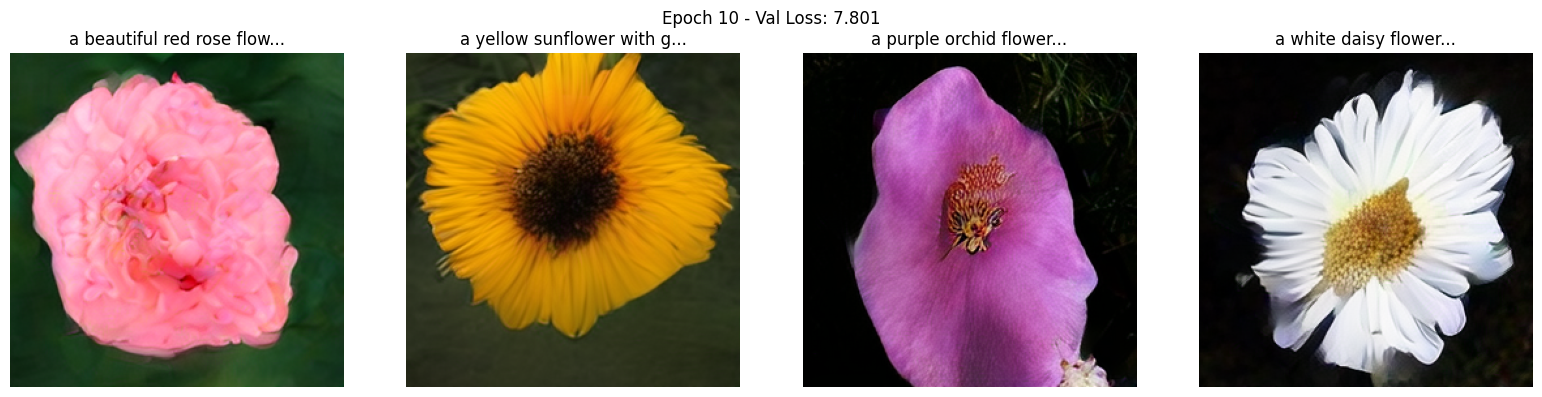

Epoch 10 done. Loss: 7.8987, Acc: 0.6%
----------------------------------------------------------------------
Ep 11/100 [0/921] Loss: 7.9376 Acc: 0.6% LR: 9.93e-05
Ep 11/100 [50/921] Loss: 7.9425 Acc: 0.5% LR: 9.93e-05
Ep 11/100 [100/921] Loss: 7.9230 Acc: 0.6% LR: 9.93e-05
Ep 11/100 [150/921] Loss: 7.9388 Acc: 0.4% LR: 9.93e-05
Ep 11/100 [200/921] Loss: 7.9033 Acc: 0.5% LR: 9.93e-05
Ep 11/100 [250/921] Loss: 7.8870 Acc: 0.6% LR: 9.93e-05
Ep 11/100 [300/921] Loss: 7.9101 Acc: 0.5% LR: 9.93e-05
Ep 11/100 [350/921] Loss: 7.8927 Acc: 0.6% LR: 9.93e-05
Ep 11/100 [400/921] Loss: 7.8812 Acc: 0.8% LR: 9.93e-05
Ep 11/100 [450/921] Loss: 7.9354 Acc: 0.4% LR: 9.93e-05
Ep 11/100 [500/921] Loss: 7.8674 Acc: 0.5% LR: 9.93e-05
Ep 11/100 [550/921] Loss: 7.9077 Acc: 0.6% LR: 9.93e-05
Ep 11/100 [600/921] Loss: 7.8471 Acc: 0.7% LR: 9.93e-05
Ep 11/100 [650/921] Loss: 7.8692 Acc: 0.7% LR: 9.93e-05
Ep 11/100 [700/921] Loss: 7.9332 Acc: 0.4% LR: 9.93e-05
Ep 11/100 [750/921] Loss: 7.8858 Acc: 0.6% LR: 9.93e-

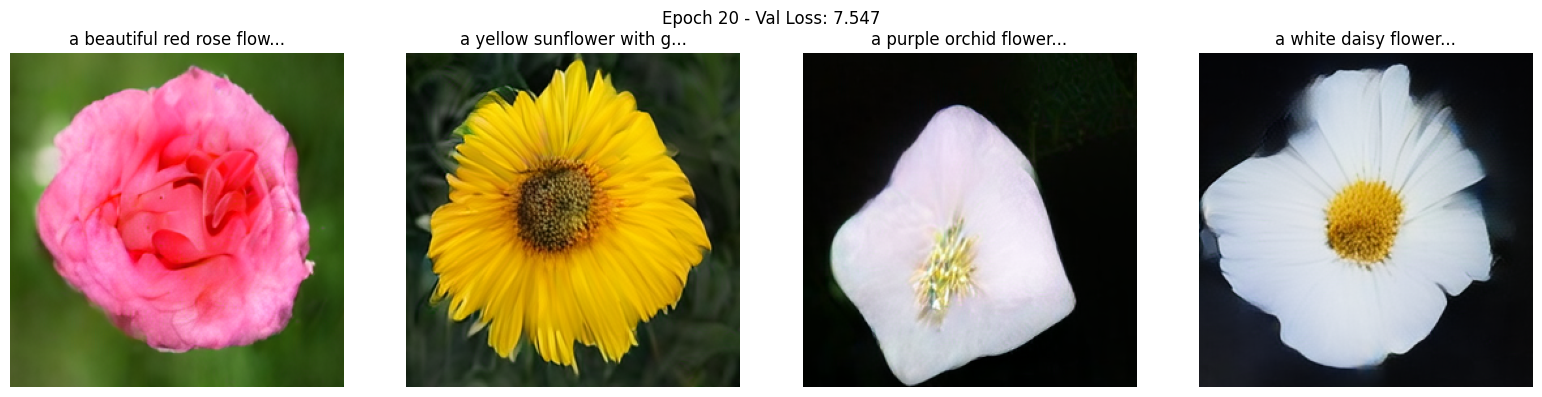

Epoch 20 done. Loss: 7.6875, Acc: 0.9%
----------------------------------------------------------------------
Ep 21/100 [0/921] Loss: 7.7309 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [50/921] Loss: 7.7325 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [100/921] Loss: 7.6901 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [150/921] Loss: 7.7156 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [200/921] Loss: 7.6541 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [250/921] Loss: 7.6616 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [300/921] Loss: 7.7015 Acc: 1.0% LR: 9.40e-05
Ep 21/100 [350/921] Loss: 7.6648 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [400/921] Loss: 7.6392 Acc: 1.3% LR: 9.40e-05
Ep 21/100 [450/921] Loss: 7.6786 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [500/921] Loss: 7.6362 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [550/921] Loss: 7.6721 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [600/921] Loss: 7.6320 Acc: 1.4% LR: 9.40e-05
Ep 21/100 [650/921] Loss: 7.6331 Acc: 1.2% LR: 9.40e-05
Ep 21/100 [700/921] Loss: 7.6953 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [750/921] Loss: 7.6513 Acc: 0.8% LR: 9.40e-

In [ ]:
# ===== CELL 13: TRAINING LOOP =====

best_val_loss = float('inf')
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("="*70)
print(f"TRAINING VAR TEXT-TO-IMAGE MODEL")
print(f"="*70)
print(f"Model: depth={cfg.var_depth}, dim={cfg.var_embed_dim}, heads={cfg.var_num_heads}")
print(f"Params: {trainable_params/1e6:.1f}M")
print(f"Dataset: {len(train_ds)} train, {len(val_ds)} val")
print(f"Batch: {cfg.batch_size} x {cfg.grad_accum} = {cfg.batch_size * cfg.grad_accum} effective")
print("="*70 + "\n")

for epoch in range(cfg.epochs):
    # Update learning rate
    current_lr = get_lr(epoch)
    for pg in optimizer.param_groups:
        pg['lr'] = current_lr

    # Training
    var.train()
    epoch_loss = 0.
    epoch_acc = 0.
    optimizer.zero_grad()

    for batch_idx, (imgs, txts) in enumerate(train_loader):
        imgs = imgs.to(device)

        with torch.no_grad():
            text_emb = encode_text(txts)
            idxs = vae.img_to_idxBl(imgs)
            gt = torch.cat(idxs, dim=1)
            x_in = vae.quantize.idxBl_to_var_input(idxs)

        with torch.amp.autocast('cuda'):
            logits = var(text_emb, x_in)
            loss = criterion(logits.view(-1, cfg.V), gt.view(-1)).view(imgs.shape[0], -1)
            loss = (loss * loss_weight).sum(-1).mean()
            loss = loss / cfg.grad_accum

        scaler.scale(loss).backward()

        if (batch_idx + 1) % cfg.grad_accum == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(var.parameters(), cfg.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        with torch.no_grad():
            acc = (logits.argmax(-1) == gt).float().mean().item() * 100

        epoch_loss += loss.item() * cfg.grad_accum
        epoch_acc += acc

        if batch_idx % cfg.log_every == 0:
            print(f"Ep {epoch+1}/{cfg.epochs} [{batch_idx}/{len(train_loader)}] "
                  f"Loss: {loss.item()*cfg.grad_accum:.4f} Acc: {acc:.1f}% LR: {current_lr:.2e}")

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Validation
    if (epoch + 1) % cfg.save_every == 0:
        var.eval()
        val_loss = 0.
        val_acc = 0.

        with torch.no_grad():
            for imgs, txts in val_loader:
                imgs = imgs.to(device)
                text_emb = encode_text(txts)
                idxs = vae.img_to_idxBl(imgs)
                gt = torch.cat(idxs, dim=1)
                x_in = vae.quantize.idxBl_to_var_input(idxs)

                with torch.amp.autocast('cuda'):
                    logits = var(text_emb, x_in)

                val_loss += F.cross_entropy(logits.view(-1, cfg.V), gt.view(-1)).item()
                val_acc += (logits.argmax(-1) == gt).float().mean().item() * 100

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\n*** Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Acc={epoch_acc:.1f}% | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.1f}% ***")

        # Save checkpoint
        ckpt = {
            'epoch': epoch,
            'model': var.state_dict(),
            'optimizer': optimizer.state_dict(),
            'history': history,
            'config': {k: v for k, v in vars(cfg).items() if not k.startswith('_')}
        }
        torch.save(ckpt, f"{cfg.output_dir}/ckpt_last.pth")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(ckpt, f"{cfg.output_dir}/ckpt_best.pth")
            print("*** Best model saved! ***")

    # Generate samples
    if (epoch + 1) % cfg.generate_every == 0:
        print("\nGenerating samples...")
        var.eval()
        with torch.no_grad():
            test_emb = encode_text(test_prompts)
            samples = var.generate(test_emb, cfg=1.5, top_k=900, top_p=0.96, seed=42)

        fig, axes = plt.subplots(1, len(test_prompts), figsize=(4*len(test_prompts), 4))
        for i, (img, prompt) in enumerate(zip(samples, test_prompts)):
            img_np = img.permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(img_np.clip(0, 1))
            axes[i].set_title(prompt[:25] + "...")
            axes[i].axis('off')
        plt.suptitle(f"Epoch {epoch+1} - Val Loss: {val_loss:.3f}")
        plt.tight_layout()
        plt.savefig(f"{cfg.output_dir}/samples_ep{epoch+1}.png", dpi=150)
        plt.show()
        var.train()

    print(f"Epoch {epoch+1} done. Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.1f}%")
    print("-" * 70)

print(f"\n{'='*70}")
print(f"Training complete! Best val loss: {best_val_loss:.4f}")
print(f"{'='*70}")

✓ Resumed from epoch 20
  Train losses recorded: 20
  Best val loss: 7.5469
RESUMING TRAINING FROM EPOCH 21



/tmp/ipython-input-525428324.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Ep 21/100 [0/921] Loss: 7.6941 Acc: 1.0% LR: 9.40e-05
Ep 21/100 [50/921] Loss: 7.6813 Acc: 1.2% LR: 9.40e-05
Ep 21/100 [100/921] Loss: 7.6752 Acc: 1.0% LR: 9.40e-05
Ep 21/100 [150/921] Loss: 7.6450 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [200/921] Loss: 7.6255 Acc: 1.1% LR: 9.40e-05
Ep 21/100 [250/921] Loss: 7.6927 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [300/921] Loss: 7.6663 Acc: 1.1% LR: 9.40e-05
Ep 21/100 [350/921] Loss: 7.6397 Acc: 1.2% LR: 9.40e-05
Ep 21/100 [400/921] Loss: 7.7019 Acc: 1.3% LR: 9.40e-05
Ep 21/100 [450/921] Loss: 7.6829 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [500/921] Loss: 7.6680 Acc: 0.8% LR: 9.40e-05
Ep 21/100 [550/921] Loss: 7.6604 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [600/921] Loss: 7.6947 Acc: 1.0% LR: 9.40e-05
Ep 21/100 [650/921] Loss: 7.6595 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [700/921] Loss: 7.7046 Acc: 0.9% LR: 9.40e-05
Ep 21/100 [750/921] Loss: 7.6521 Acc: 1.0% LR: 9.40e-05
Ep 21/100 [800/921] Loss: 7.6097 Acc: 1.3% LR: 9.40e-05
Ep 21/100 [850/921] Loss: 7.6432 Acc: 1.0% LR: 9.40

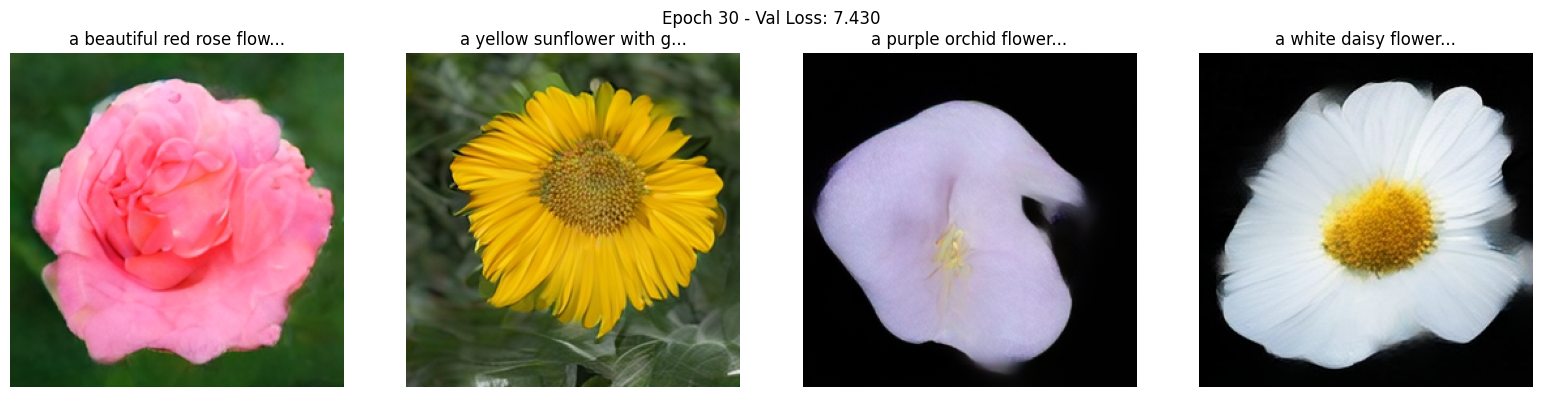

Epoch 30 done. Loss: 7.5653, Acc: 1.2%
----------------------------------------------------------------------
Ep 31/100 [0/921] Loss: 7.6132 Acc: 1.1% LR: 8.40e-05
Ep 31/100 [50/921] Loss: 7.6303 Acc: 1.1% LR: 8.40e-05
Ep 31/100 [100/921] Loss: 7.5695 Acc: 1.3% LR: 8.40e-05
Ep 31/100 [150/921] Loss: 7.5661 Acc: 1.2% LR: 8.40e-05
Ep 31/100 [200/921] Loss: 7.5537 Acc: 1.1% LR: 8.40e-05
Ep 31/100 [250/921] Loss: 7.5715 Acc: 1.0% LR: 8.40e-05
Ep 31/100 [300/921] Loss: 7.5902 Acc: 1.3% LR: 8.40e-05
Ep 31/100 [350/921] Loss: 7.5683 Acc: 0.9% LR: 8.40e-05
Ep 31/100 [400/921] Loss: 7.5331 Acc: 1.3% LR: 8.40e-05
Ep 31/100 [450/921] Loss: 7.5740 Acc: 1.0% LR: 8.40e-05
Ep 31/100 [500/921] Loss: 7.5152 Acc: 1.2% LR: 8.40e-05
Ep 31/100 [550/921] Loss: 7.5508 Acc: 1.4% LR: 8.40e-05
Ep 31/100 [600/921] Loss: 7.5295 Acc: 1.6% LR: 8.40e-05
Ep 31/100 [650/921] Loss: 7.5375 Acc: 1.2% LR: 8.40e-05
Ep 31/100 [700/921] Loss: 7.5899 Acc: 0.9% LR: 8.40e-05
Ep 31/100 [750/921] Loss: 7.5421 Acc: 1.1% LR: 8.40e-

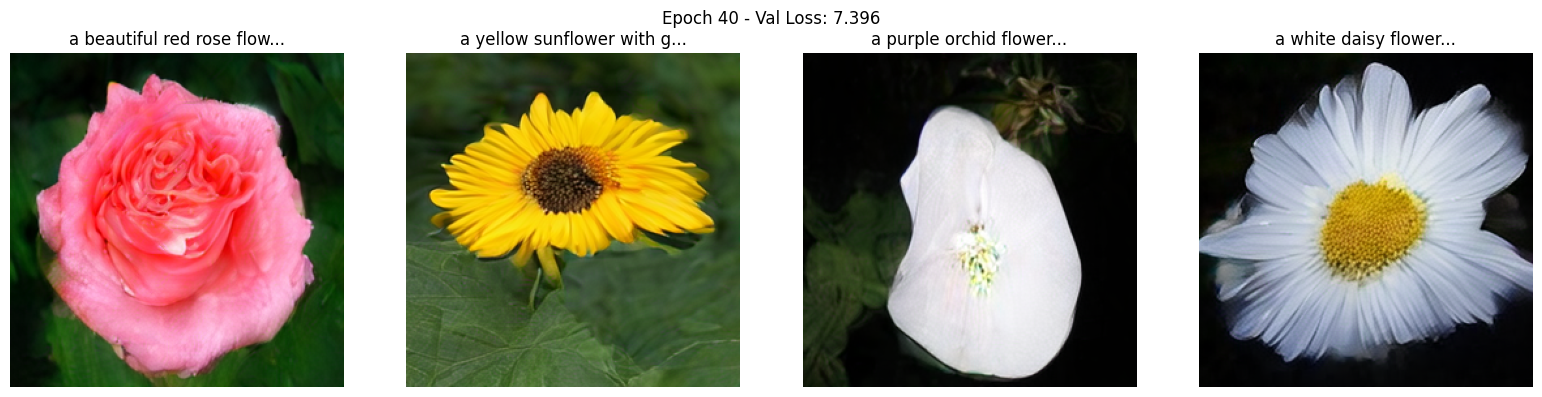

Epoch 40 done. Loss: 7.4794, Acc: 1.4%
----------------------------------------------------------------------
Ep 41/100 [0/921] Loss: 7.5211 Acc: 1.5% LR: 7.04e-05


KeyboardInterrupt: 

In [19]:
# ===== RESUME TRAINING (models already loaded) =====

# Load checkpoint
checkpoint_path = f"{cfg.output_dir}/ckpt_last.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model and optimizer state
var.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

# Get training state
start_epoch = checkpoint['epoch'] + 1
history = checkpoint.get('history', {'train_loss': [], 'val_loss': [], 'scale_losses': []})
best_val_loss = min(history['val_loss']) if history['val_loss'] else float('inf')

print(f"✓ Resumed from epoch {start_epoch}")
print(f"  Train losses recorded: {len(history['train_loss'])}")
print(f"  Best val loss: {best_val_loss:.4f}" if best_val_loss < float('inf') else "  No validation yet")

print("="*70)
print(f"RESUMING TRAINING FROM EPOCH {start_epoch + 1}")
print("="*70 + "\n")

for epoch in range(start_epoch,cfg.epochs):
    # Update learning rate
    current_lr = get_lr(epoch)
    for pg in optimizer.param_groups:
        pg['lr'] = current_lr

    # Training
    var.train()
    epoch_loss = 0.
    epoch_acc = 0.
    optimizer.zero_grad()

    for batch_idx, (imgs, txts) in enumerate(train_loader):
        imgs = imgs.to(device)

        with torch.no_grad():
            text_emb = encode_text(txts)
            idxs = vae.img_to_idxBl(imgs)
            gt = torch.cat(idxs, dim=1)
            x_in = vae.quantize.idxBl_to_var_input(idxs)

        with torch.amp.autocast('cuda'):
            logits = var(text_emb, x_in)
            loss = criterion(logits.view(-1, cfg.V), gt.view(-1)).view(imgs.shape[0], -1)
            loss = (loss * loss_weight).sum(-1).mean()
            loss = loss / cfg.grad_accum

        scaler.scale(loss).backward()

        if (batch_idx + 1) % cfg.grad_accum == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(var.parameters(), cfg.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        with torch.no_grad():
            acc = (logits.argmax(-1) == gt).float().mean().item() * 100

        epoch_loss += loss.item() * cfg.grad_accum
        epoch_acc += acc

        if batch_idx % cfg.log_every == 0:
            print(f"Ep {epoch+1}/{cfg.epochs} [{batch_idx}/{len(train_loader)}] "
                  f"Loss: {loss.item()*cfg.grad_accum:.4f} Acc: {acc:.1f}% LR: {current_lr:.2e}")

    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)

    # Validation
    if (epoch + 1) % cfg.save_every == 0:
        var.eval()
        val_loss = 0.
        val_acc = 0.

        with torch.no_grad():
            for imgs, txts in val_loader:
                imgs = imgs.to(device)
                text_emb = encode_text(txts)
                idxs = vae.img_to_idxBl(imgs)
                gt = torch.cat(idxs, dim=1)
                x_in = vae.quantize.idxBl_to_var_input(idxs)

                with torch.amp.autocast('cuda'):
                    logits = var(text_emb, x_in)

                val_loss += F.cross_entropy(logits.view(-1, cfg.V), gt.view(-1)).item()
                val_acc += (logits.argmax(-1) == gt).float().mean().item() * 100

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"\n*** Epoch {epoch+1}: Train Loss={epoch_loss:.4f}, Acc={epoch_acc:.1f}% | "
              f"Val Loss={val_loss:.4f}, Acc={val_acc:.1f}% ***")

        # Save checkpoint
        ckpt = {
            'epoch': epoch,
            'model': var.state_dict(),
            'optimizer': optimizer.state_dict(),
            'history': history,
            'config': {k: v for k, v in vars(cfg).items() if not k.startswith('_')}
        }
        torch.save(ckpt, f"{cfg.output_dir}/ckpt_last.pth")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(ckpt, f"{cfg.output_dir}/ckpt_best.pth")
            print("*** Best model saved! ***")

    # Generate samples
    if (epoch + 1) % cfg.generate_every == 0:
        print("\nGenerating samples...")
        var.eval()
        with torch.no_grad():
            test_emb = encode_text(test_prompts)
            samples = var.generate(test_emb, cfg=1.5, top_k=900, top_p=0.96, seed=42)

        fig, axes = plt.subplots(1, len(test_prompts), figsize=(4*len(test_prompts), 4))
        for i, (img, prompt) in enumerate(zip(samples, test_prompts)):
            img_np = img.permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(img_np.clip(0, 1))
            axes[i].set_title(prompt[:25] + "...")
            axes[i].axis('off')
        plt.suptitle(f"Epoch {epoch+1} - Val Loss: {val_loss:.3f}")
        plt.tight_layout()
        plt.savefig(f"{cfg.output_dir}/samples_ep{epoch+1}.png", dpi=150)
        plt.show()
        var.train()

    print(f"Epoch {epoch+1} done. Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.1f}%")
    print("-" * 70)

print(f"\n{'='*70}")
print(f"Training complete! Best val loss: {best_val_loss:.4f}")
print(f"{'='*70}")

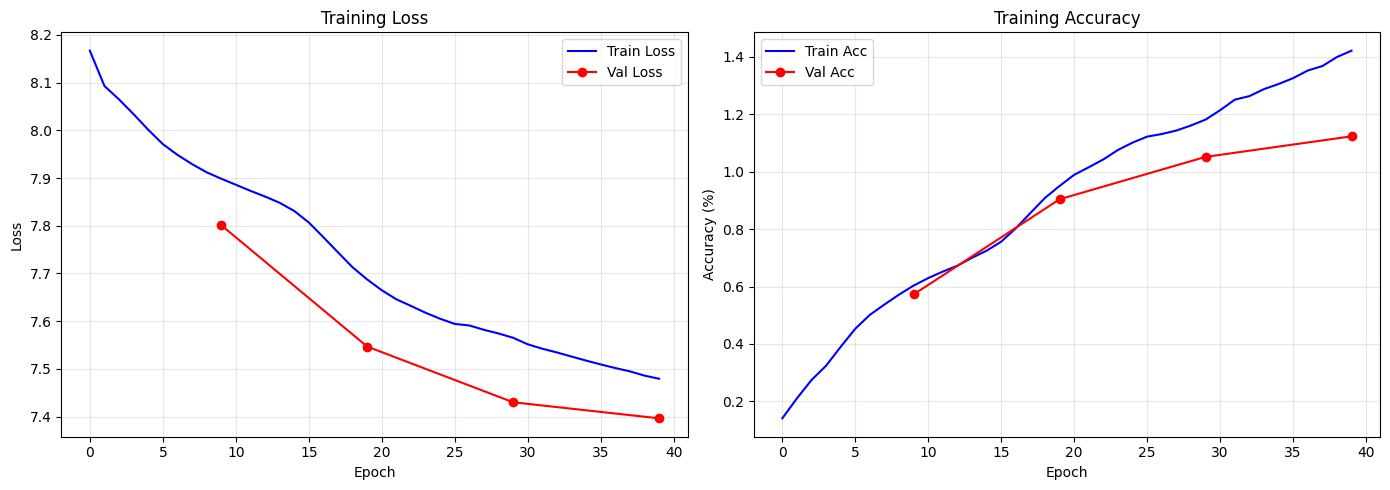

In [20]:
# ===== CELL 14: PLOT TRAINING HISTORY =====

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
if history['val_loss']:
    val_epochs = list(range(cfg.save_every-1, len(history['train_loss']), cfg.save_every))
    axes[0].plot(val_epochs, history['val_loss'], label='Val Loss', color='red', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
if history['val_acc']:
    val_epochs = list(range(cfg.save_every-1, len(history['train_acc']), cfg.save_every))
    axes[1].plot(val_epochs, history['val_acc'], label='Val Acc', color='red', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{cfg.output_dir}/training_history.png", dpi=150)
plt.show()

In [17]:
# ===== CELL 15: GENERATE IMAGES FROM CUSTOM PROMPTS =====

# Load best model
ckpt = torch.load(f"{cfg.output_dir}/ckpt_best.pth", map_location=device)
var.load_state_dict(ckpt['model'])
var.eval()
print(f"Loaded best model from epoch {ckpt['epoch']+1}")

# Custom prompts
custom_prompts = [
    "a beautiful pink rose flower",
    "a bright yellow sunflower",
    "a purple iris flower",
    "a white lily flower",
    "a red tulip flower",
    "an orange marigold flower",
]

# Generate with different CFG scales
cfg_scales = [1.0, 1.5, 2.0, 3.0]

fig, axes = plt.subplots(len(custom_prompts), len(cfg_scales), figsize=(4*len(cfg_scales), 4*len(custom_prompts)))

for i, prompt in enumerate(custom_prompts):
    with torch.no_grad():
        text_emb = encode_text([prompt])
        for j, cfg_scale in enumerate(cfg_scales):
            img = var.generate(text_emb, cfg=cfg_scale, top_k=900, top_p=0.96, seed=42)[0]
            img_np = img.permute(1, 2, 0).cpu().numpy()
            axes[i, j].imshow(img_np.clip(0, 1))
            axes[i, j].axis('off')
            if i == 0:
                axes[i, j].set_title(f"CFG={cfg_scale}")
    axes[i, 0].set_ylabel(prompt[:20] + "...", fontsize=10)

plt.suptitle("Generated Images with Different CFG Scales", fontsize=14)
plt.tight_layout()
plt.savefig(f"{cfg.output_dir}/generated_samples.png", dpi=150)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

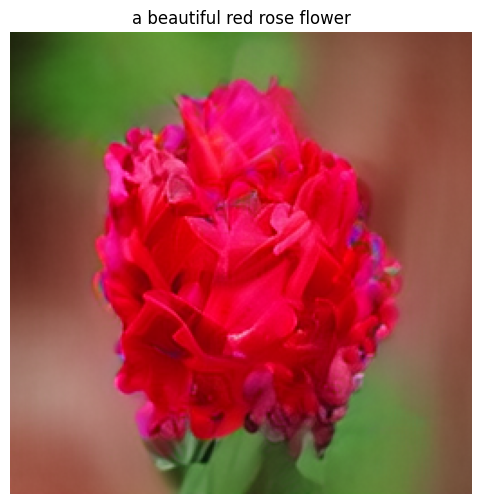

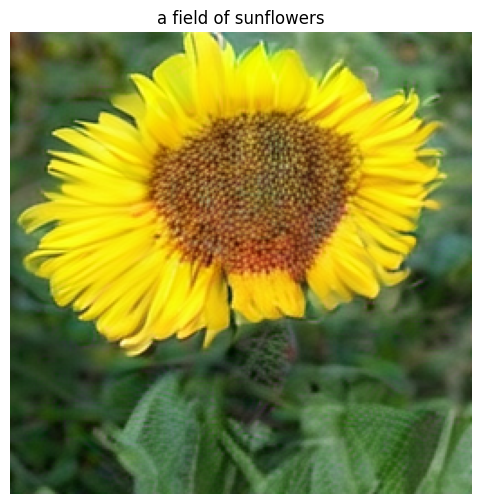

✓ Interactive generation ready!
Usage: generate_image('your prompt here', cfg_scale=1.5, seed=42)


In [32]:
# ===== CELL 16: INTERACTIVE GENERATION =====

def generate_image(prompt, cfg_scale=1.5, top_k=900, top_p=0.96, seed=None):
    """Generate an image from a text prompt"""
    var.eval()
    with torch.no_grad():
        text_emb = encode_text([prompt])
        img = var.generate(text_emb, cfg=cfg_scale, top_k=top_k, top_p=top_p, seed=seed)[0]
        img_np = img.permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(img_np.clip(0, 1))
    plt.title(prompt)
    plt.axis('off')
    plt.show()
    return img_np

# Example usage:
generate_image("a beautiful red rose flower", cfg_scale=2.0)
generate_image("a field of sunflowers", cfg_scale=1.5, seed=123)

print("✓ Interactive generation ready!")
print("Usage: generate_image('your prompt here', cfg_scale=1.5, seed=42)")

In [17]:
# ===== DEBUG: CHECK DATASET LOADING =====

from pathlib import Path

dataset_path = '/content/drive/MyDrive/flowers_dataset'

# Check what files exist
all_files = list(Path(dataset_path).glob('*'))
jpg_files = list(Path(dataset_path).glob('*.jpg'))
txt_files = list(Path(dataset_path).glob('*.txt'))

print(f"Total files in folder: {len(all_files)}")
print(f"JPG files: {len(jpg_files)}")
print(f"TXT files: {len(txt_files)}")

# Check paired files (both jpg AND txt exist)
paired = []
for jpg in jpg_files:
    txt = jpg.with_suffix('.txt')
    if txt.exists():
        paired.append((jpg, txt))

print(f"Properly paired: {len(paired)}")

# Check first few files
print("\nFirst 10 JPG files:")
for f in sorted(jpg_files)[:10]:
    print(f"  {f.name}")

print("\nFirst 10 TXT files:")
for f in sorted(txt_files)[:10]:
    print(f"  {f.name}")

# Check if there are subdirectories
subdirs = [f for f in all_files if f.is_dir()]
print(f"\nSubdirectories: {len(subdirs)}")
for d in subdirs[:5]:
    print(f"  {d.name}")

Total files in folder: 4605
JPG files: 2303
TXT files: 2302
Properly paired: 2302

First 10 JPG files:
  00000.jpg
  00001.jpg
  00002.jpg
  00003.jpg
  00004.jpg
  00005.jpg
  00006.jpg
  00007.jpg
  00008.jpg
  00009.jpg

First 10 TXT files:
  00000.txt
  00001.txt
  00002.txt
  00003.txt
  00004.txt
  00005.txt
  00006.txt
  00007.txt
  00008.txt
  00009.txt

Subdirectories: 0


In [18]:
# ===== CHECK THE DATASET CLASS =====

# Let's manually test the dataset loading
from pathlib import Path

dataset_path = Path('/content/drive/MyDrive/flowers_dataset')

# This is what the Dataset class does:
pairs = [(p, p.with_suffix('.txt')) for p in dataset_path.glob('*')
         if p.suffix.lower() in ['.jpg', '.jpeg', '.png'] and p.with_suffix('.txt').exists()]

print(f"Dataset class finds: {len(pairs)} pairs")

# If this is less than 8189, check why
if len(pairs) < 8000:
    # Check file extensions
    all_images = list(dataset_path.glob('*.jpg')) + list(dataset_path.glob('*.jpeg')) + list(dataset_path.glob('*.png'))
    print(f"\nTotal image files: {len(all_images)}")

    # Check for missing txt files
    missing_txt = 0
    for img in all_images[:100]:
        if not img.with_suffix('.txt').exists():
            missing_txt += 1
            print(f"  Missing txt for: {img.name}")
    print(f"Missing txt files (first 100): {missing_txt}")

Dataset class finds: 2302 pairs

Total image files: 2303
Missing txt files (first 100): 0
